Loading Single Cell RNA-seq data obtained from Gene Expression Omnibus (or using wget https://weilab.math.msu.edu/Downloads/MDG/scRNA-seq-data.zip   in terminal)

In [98]:
import numpy as np
import pandas as pd
import anndata
import scanpy as sc

def load_X(data, inpath):
    X = pd.read_csv(inpath + '%s_data.csv'%(data))
    X = X.values[:, 1:].astype(float)
    return X

def load_y(data, inpath):
    y = pd.read_csv(inpath + '%s_labels.csv'%(data))
    y = np.array(list(y['Label'])).astype(int)
    return y

In [99]:
ID = 'GSE75748time'
expression = pd.read_csv(f'/mnt/home/cottre61/GFP-GAT/STAGATE_pyG/scRNAseq-TopAnalysis/Data/scRNA-seq-data/{ID}/{ID}_data.csv', index_col=0)
y = load_y(ID, f'/mnt/home/cottre61/GFP-GAT/STAGATE_pyG/scRNAseq-TopAnalysis/Data/scRNA-seq-data/{ID}/')
expression = expression.T # cells by genes

In [100]:
adata = anndata.AnnData(expression)
adata.obs['cell_label'] = y # cell types
adata

AnnData object with n_obs × n_vars = 758 × 19189
    obs: 'cell_label'

The AnnData structure in python also conveniently stores gene names

In [101]:
adata.var_names

Index(['A1BG', 'A1CF', 'A2LD1', 'A2M', 'A2ML1', 'A4GALT', 'A4GNT', 'AAAS',
       'AACS', 'AADAC',
       ...
       'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=19189)

As well as cell identifiers

In [102]:
adata.obs_names

Index(['GSM1965778', 'GSM1965779', 'GSM1965780', 'GSM1965781', 'GSM1965782',
       'GSM1965783', 'GSM1965784', 'GSM1965785', 'GSM1965786', 'GSM1965787',
       ...
       'GSM1966526', 'GSM1966527', 'GSM1966528', 'GSM1966529', 'GSM1966530',
       'GSM1966531', 'GSM1966532', 'GSM1966533', 'GSM1966534', 'GSM1966535'],
      dtype='object', length=758)

And cell type labels

In [103]:
adata.obs['cell_label'] # in this case, just stored as integer values 

GSM1965778    0
GSM1965779    0
GSM1965780    0
GSM1965781    0
GSM1965782    0
             ..
GSM1966531    5
GSM1966532    5
GSM1966533    5
GSM1966534    5
GSM1966535    5
Name: cell_label, Length: 758, dtype: int64

Scanpy allows us to do several basic analyses on the gene expression data via the adata object. This includes dimensionality reduction via PCA, clustering of cells via Leiden or Louvain, or data visuazliation with UMAP and tSNE. 

Prior to any analysis, we should filter and pre-process the data. 

In [104]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata = adata[:, adata.var['highly_variable']]
adata

/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


View of AnnData object with n_obs × n_vars = 758 × 3000
    obs: 'cell_label'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'

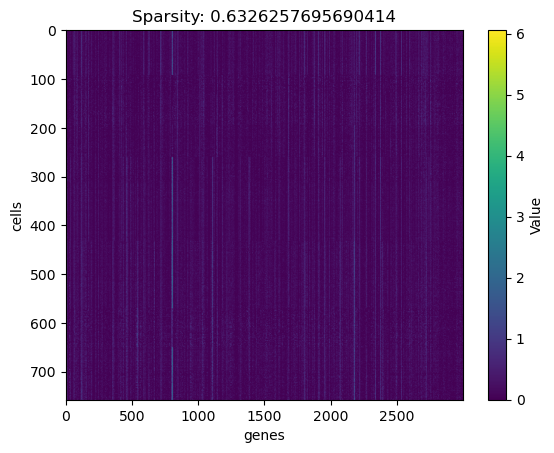

In [105]:
import matplotlib.pyplot as plt
total_elements = adata.X.size
zero_elements = np.sum(adata.X < 1e-6)
sparsity = zero_elements / total_elements

plt.imshow(adata.X, aspect='auto', cmap='viridis')
plt.colorbar(label='Value')
plt.title(f'Sparsity: {sparsity}')
plt.xlabel("genes")
plt.ylabel("cells")
plt.show()

### Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a statistical technique used for dimensionality reduction, feature extraction, and data visualization. It transforms high-dimensional data into a lower-dimensional space while preserving as much variance as possible.

---

### How PCA Works Mathematically

###  **Compute the Covariance Matrix**
   - The covariance matrix captures the relationships between features:

   $\Sigma = \frac{1}{n-1} X^\top X$

### **Perform Eigen Decomposition**
   - Calculate the eigenvalues $ \lambda $ and eigenvectors $ v $ of the covariance matrix:

   $\Sigma v = \lambda v$

   - The eigenvalues represent the variance captured by each principal component (direction in space).
   - The eigenvectors define the directions of the principal components.

### **Sort Eigenvalues and Eigenvectors**
   - Rank the eigenvalues in descending order and sort the corresponding eigenvectors with their corresponding eignvalues.

### **Project Data onto Principal Components**
   - Select the top $k$ eigenvectors (corresponding to the $k$-largest or smallest eigenvalues) to form the projection matrix $W$.
   - Transform the data:

   $X_{\text{PCA}} = XW$

---

### Key Properties
- PCA maximizes variance in the data for the selected dimensions.
- Principal components are orthogonal (uncorrelated).

In [106]:
# naive implementation of PCA
def PCA_Algorithm(xMat,k):
    S = (xMat.T * xMat)
    S_eigVals, S_eigVects = np.linalg.eig(S)
    eigValIndice = np.argsort(S_eigVals)
    n_eigValIndice = eigValIndice[0:k]
    n_S_eigVect = S_eigVects[:, n_eigValIndice]
    W = np.array(n_S_eigVect)  
    wMat = np.array(W)  
    Y = xMat * wMat  
    return Y

In [107]:
# PCA in Scanpy
sc.tl.pca(adata, n_comps=50)
adata

/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


AnnData object with n_obs × n_vars = 758 × 3000
    obs: 'cell_label'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

The most introductory clustering algorithm is KMeans. 

### K-Means Clustering

K-Means is an unsupervised machine learning algorithm used for clustering data into a specified number of groups (clusters). It aims to minimize the within-cluster variance.

---

### How K-Means Works Mathematically

### **Initialize Cluster Centers**
   - Choose $n$ initial cluster centroids, either randomly or based on heuristics.

### **Assign Data Points to Clusters**
   - Assign each data point $x_i$ to the nearest cluster based on the Euclidean distance:

   $ \text{Cluster}(x_i) = \arg \min_{j} \| x_i - c_j \|^2 $

   where $c_j$ is the centroid of cluster $j$.

### **Update Cluster Centroids**
   - Recompute each cluster's centroid as the mean of all data points assigned to it:

   $ c_j = \frac{1}{m_j} \sum_{x_i \in \text{Cluster}_j} x_i $

   where $m_j$ is the number of points in cluster $j$.

### **Iterate**
   - Repeat steps 2 and 3 until the centroids stabilize (i.e., there is little to no change in assignments or centroids).

---

### Objective Function
K-Means minimizes the sum of squared distances between each point and its cluster centroid:

$ J = \sum_{j=1}^{n} \sum_{x_i \in \text{Cluster}_j} \| x_i - c_j \|^2 $

---

### Properties
- **Convergence**: The algorithm is guaranteed to converge to a local minimum of the objective function.
- **Initialization Sensitivity**: Results depend on the choice of initial centroids.

---


In [108]:
import matplotlib.pyplot as plt

# K-Means from scratch
class my_KMeans:
    def __init__(self, k, max_iters=100, tolerance=1e-4, state=42):
        self.k = k
        self.max_iters = max_iters
        self.tolerance = tolerance
        self.state = state
    
    def fit(self, data):
        # Randomly initialize centroids (random seeding determines how they are chosen)
        np.random.seed(self.state)
        random_indices = np.random.choice(data.shape[0], self.k, replace=False) # select some subset of k cells to assign as centroids
        self.centroids = data[random_indices] # extract those cells locations
        
        for _ in range(self.max_iters):
            # Assign clusters to each cell
            self.clusters = self._assign_clusters(data)
            # Compute new centroids # given cell distances
            new_centroids = self._compute_centroids(data)
            # Check for convergence
            if np.all(np.abs(new_centroids - self.centroids) < self.tolerance):
                break
            self.centroids = new_centroids
        return self
    
    def _assign_clusters(self, data):
        distances = np.linalg.norm(data[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)
    
    def _compute_centroids(self, data):
        centroids = np.zeros((self.k, data.shape[1]))
        for i in range(self.k):
            cluster_points = data[self.clusters == i]
            centroids[i] = cluster_points.mean(axis=0)
        return centroids
    
    def predict(self, data):
        return self._assign_clusters(data)


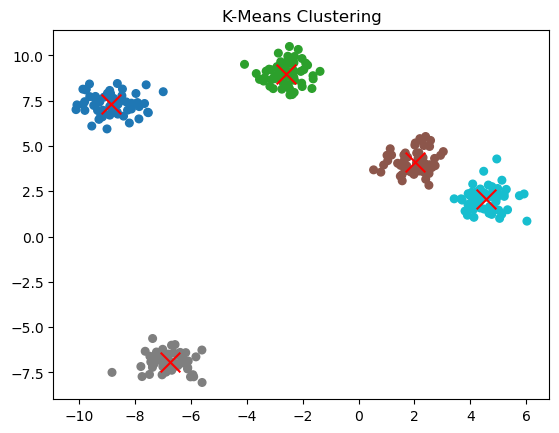

In [110]:
# Generate synthetic data
from sklearn.datasets import make_blobs

data, _ = make_blobs(n_samples=300, centers=5, cluster_std=0.60, random_state=42)

# Run K-Means
#kmeans = my_KMeans(k=5, state=42)
kmeans = my_KMeans(k=5, state=20)
kmeans.fit(data)

# Plot
plt.scatter(data[:, 0], data[:, 1], c=kmeans.clusters, cmap='tab10', s=30)
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', s=200, marker='x')
plt.title('K-Means Clustering')
plt.show()

In [111]:
from sklearn.cluster import KMeans
# KMeans in sklearn
def kmeans(X, n_clusters, state):
    myKM = KMeans(n_clusters = n_clusters,  n_init = 150, random_state = state)
    myKM.fit(X)
    label = myKM.labels_
    return label

n = adata.obs['cell_label'].nunique()
adata.obs['kmeans_clusters'] = kmeans(adata.obsm['X_pca'], n, 42)
adata

AnnData object with n_obs × n_vars = 758 × 3000
    obs: 'cell_label', 'kmeans_clusters'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [112]:
# Clustering in Scanpy via Louvain and Leiden
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.louvain(adata, resolution=1.0)
sc.tl.leiden(adata, resolution=1.0)
adata

AnnData object with n_obs × n_vars = 758 × 3000
    obs: 'cell_label', 'kmeans_clusters', 'louvain', 'leiden'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'louvain', 'leiden'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

We can evaluate the efficacy of our clustering performance via some metric, such as Normalized Mutual Information (NMI) 

Normalized Mutual Information (NMI) is a metric used to evaluate the similarity between two clustering results. It measures how much information is shared between the predicted clusters and the ground truth labels.

---

The NMI between two clusterings, $A$ and $B$, is defined as:

$$
\text{NMI}(A, B) = \frac{2 \cdot I(A; B)}{H(A) + H(B)}
$$

where:
- $I(A; B)$: Mutual information between $A$ and $B$.
- $H(A)$: Entropy of clustering $A$.
- $H(B)$: Entropy of clustering $B$.

---

## Components

### 1. **Mutual Information ($I(A; B)$)**
Mutual information quantifies the amount of information shared between $A$ and $B$:

$$
I(A; B) = \sum_{i=1}^{k_A} \sum_{j=1}^{k_B} P(A_i, B_j) \log \frac{P(A_i, B_j)}{P(A_i) P(B_j)}
$$

where:
- $P(A_i)$: Probability of a data point belonging to cluster $A_i$.
- $P(B_j)$: Probability of a data point belonging to cluster $B_j$.
- $P(A_i, B_j)$: Joint probability of a data point belonging to both $A_i$ and $B_j$.

### 2. **Entropy ($H(A)$)**
Entropy measures the uncertainty of a clustering:

$$
H(A) = - \sum_{i=1}^{k_A} P(A_i) \log P(A_i)
$$

---

In [113]:
from sklearn.metrics.cluster import normalized_mutual_info_score
NMI_kmeans = normalized_mutual_info_score(adata.obs['kmeans_clusters'],  adata.obs['cell_label'])
NMI_louvain = normalized_mutual_info_score(adata.obs['louvain'],  adata.obs['cell_label'])
NMI_leiden = normalized_mutual_info_score(adata.obs['leiden'],  adata.obs['cell_label'])
print('KMeans Clustering NMI: ', NMI_kmeans)
print('Louvain Clustering NMI: ', NMI_louvain)
print('Leiden Clustering NMI: ', NMI_leiden)

KMeans Clustering NMI:  0.7880860089950085
Louvain Clustering NMI:  0.846838841796749
Leiden Clustering NMI:  0.8454956313065242


We can also visualize the results via a 2D UMAP or tSNE embedding. 

In [114]:
# UMAP visualization
sc.tl.umap(adata)

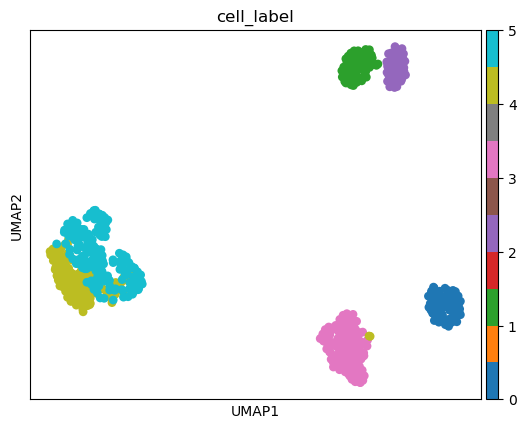

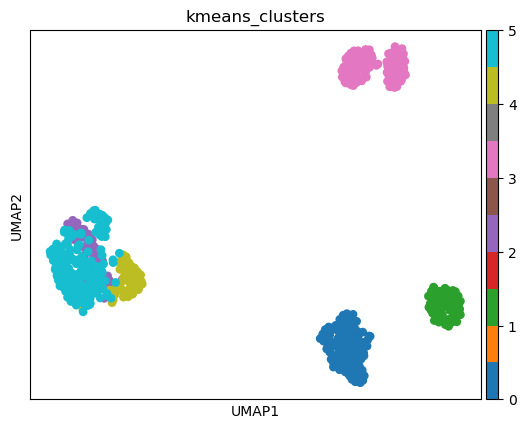

/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


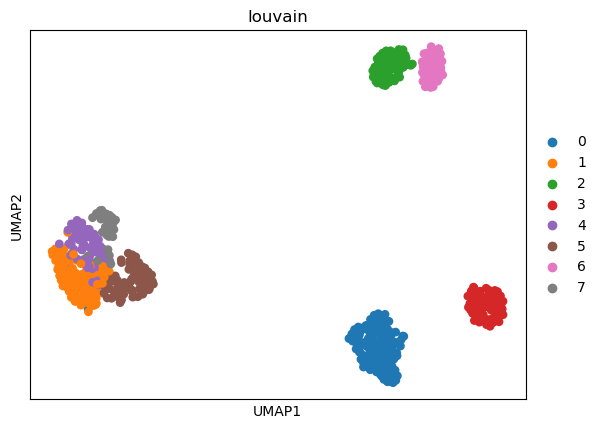

/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


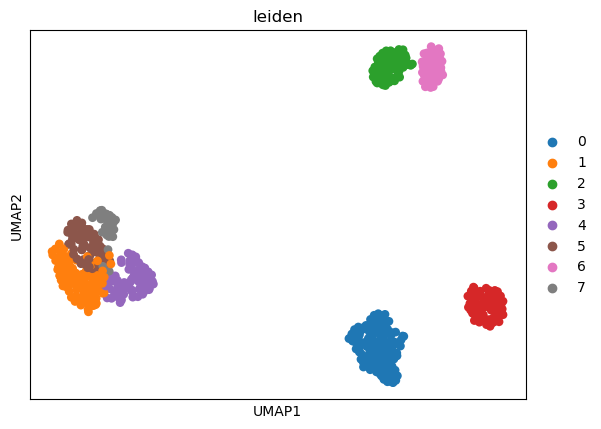

In [115]:
sc.pl.umap(adata, color='cell_label',cmap='tab10')
sc.pl.umap(adata, color='kmeans_clusters',cmap='tab10')
sc.pl.umap(adata, color='louvain',cmap='tab10')
sc.pl.umap(adata, color='leiden',cmap='tab10')

In [116]:
# tSNE visualization
sc.tl.tsne(adata)

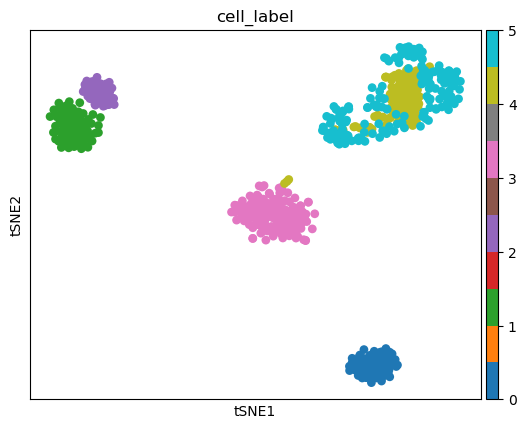

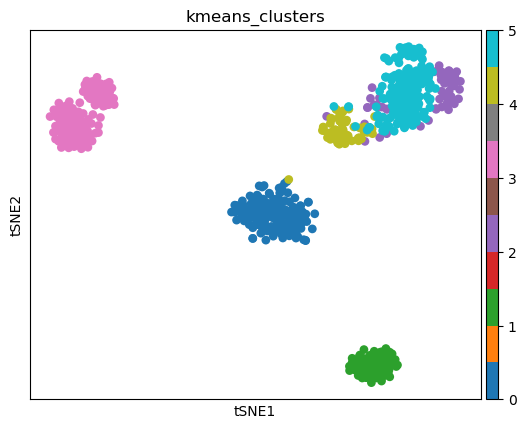

/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


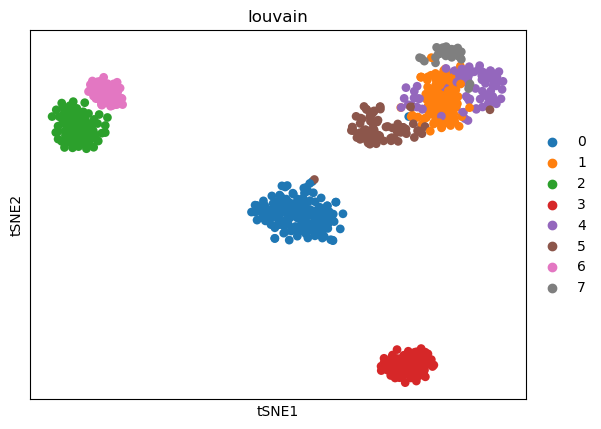

/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


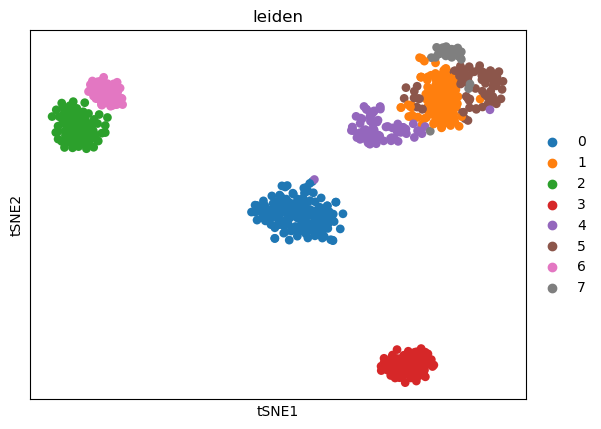

In [117]:
sc.pl.tsne(adata, color='cell_label',cmap='tab10')
sc.pl.tsne(adata, color='kmeans_clusters',cmap='tab10')
sc.pl.tsne(adata, color='louvain',cmap='tab10')
sc.pl.tsne(adata, color='leiden',cmap='tab10')

However, such methods do not account for any spatial struture in the data. How would they perform on ST data rather than scRNAseq? 

In [118]:
adata_spatial = sc.read_h5ad('/mnt/home/cottre61/GFP-GAT/STAGATE_pyG/SpatialTranscriptomics/151674.h5ad')
adata_spatial

/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3673 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_name', 'layer'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [120]:
adata_spatial.obsm['spatial']

array([[ 9733,  8533],
       [ 5713,  2873],
       [ 4011,  9569],
       ...,
       [ 4574,  7896],
       [ 5513, 11257],
       [ 6261,  3356]])

In [121]:
sc.pp.highly_variable_genes(adata_spatial, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_spatial, target_sum=1e4)
sc.pp.log1p(adata_spatial)
adata_spatial = adata_spatial[:, adata_spatial.var['highly_variable']]
adata_spatial

View of AnnData object with n_obs × n_vars = 3673 × 3003
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_name', 'layer'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial'

/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


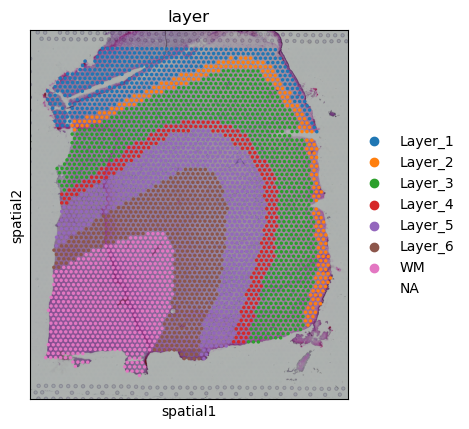

In [122]:
sc.pl.spatial(adata_spatial, color='layer',cmap='tab10')

/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


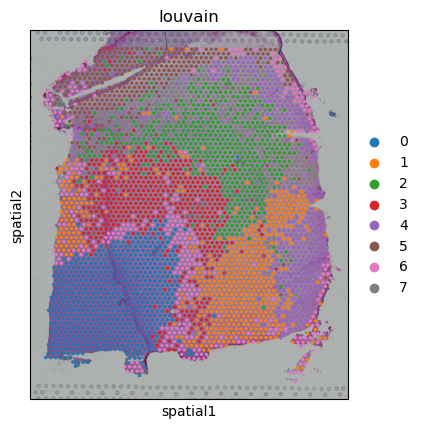

In [123]:
sc.tl.pca(adata_spatial, n_comps=50)
sc.pp.neighbors(adata_spatial, n_neighbors=10)
sc.tl.louvain(adata_spatial, resolution=1.0)
sc.pl.spatial(adata_spatial, color='louvain',cmap='tab10')

/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/mnt/home/cottre61/anaconda3/envs/GATE/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


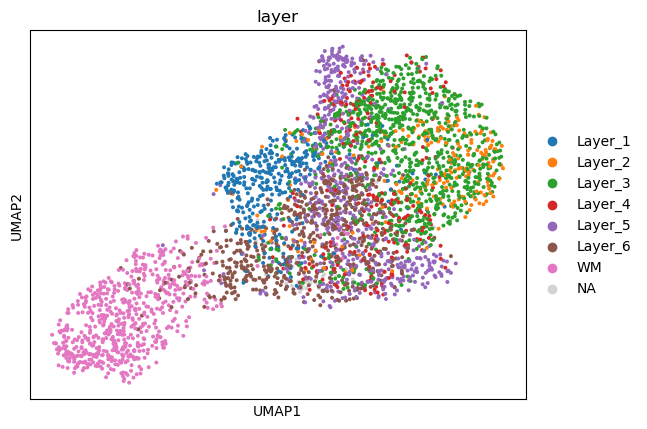

In [124]:
sc.tl.umap(adata_spatial)
sc.pl.umap(adata_spatial,color='layer',cmap='tab10')